#### 训练集：
	建议利用序号1-200图片
#### 测试集：
	建议利用序号201-236图片

### 项目要求：
	(1) 设计CNN神经网络模型，计算每张图片中煤的占比(煤炭在前景图像中的比例)
	(2) 撰写项目报告，主要包含如下章节结构
		Abstract：高度概括研究动机、思路、结果
		Introduction：研究背景与意义、主要创新点
		Related Research：相关研究调研
		Methods：采用的方法的详细说明，网络结构等
		Results：数据集，训练细节，在测试集上的实验结果等(ROC PR曲线)
		Conclusion


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython



In [2]:
import os
from PIL import Image
from load_data import load_data

X_train,y_train,X_val,y_val,X_test,y_test = load_data()
X_test1 = np.copy(X_test)
print(X_train.shape)


(180, 512, 512, 3)


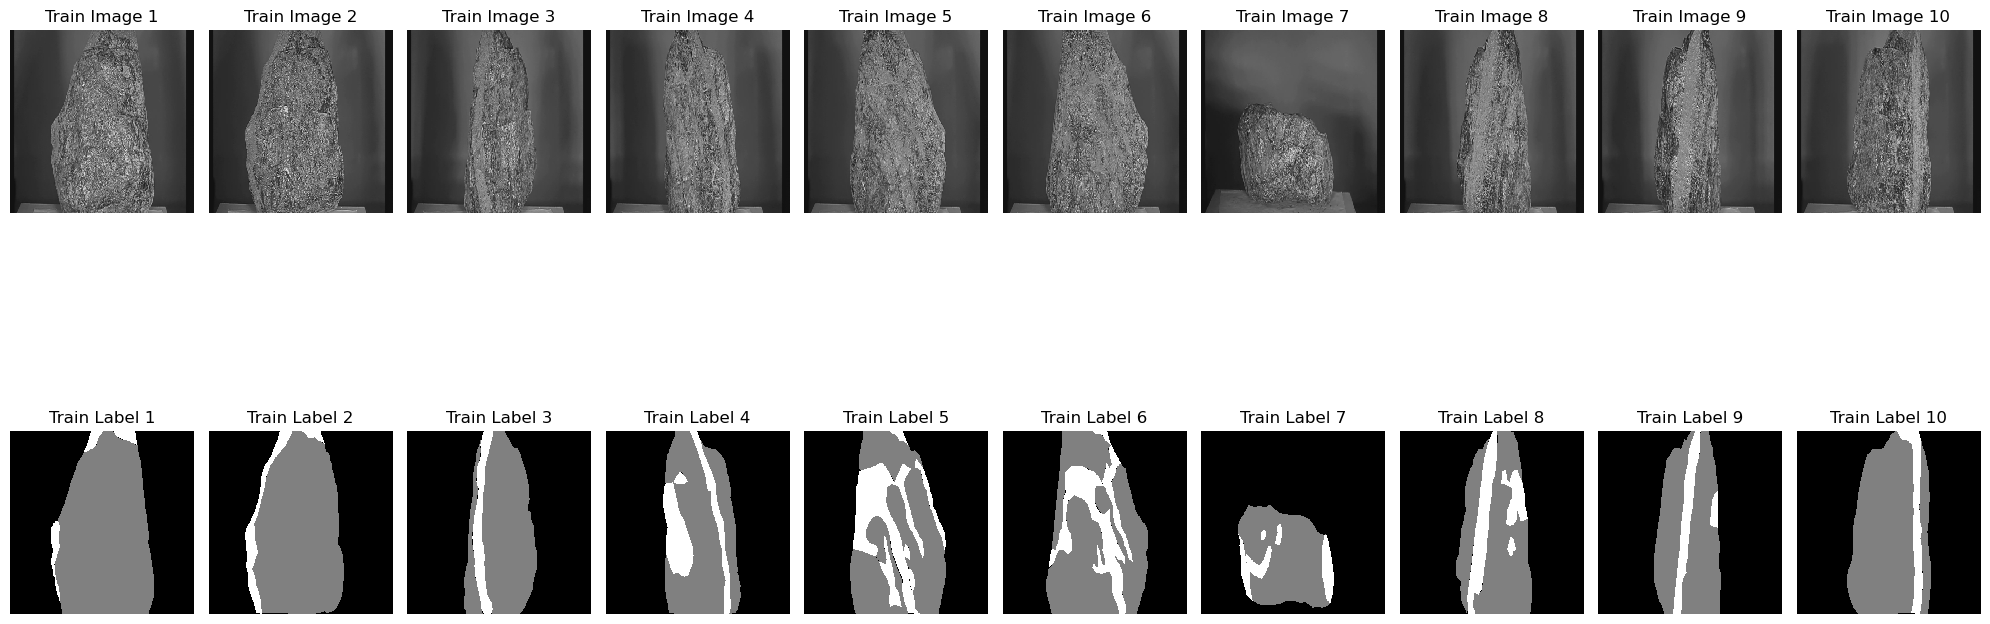

In [3]:
import matplotlib.pyplot as plt

# 设置显示大小
plt.figure(figsize=(20, 10))

# 展示前10个训练样本
for i in range(10):
    # 获取训练集中的图像和标签
    image = X_train[i]
    label = y_train[i]

    # 绘制图像
    plt.subplot(2, 10, i + 1)
    plt.imshow(image)
    plt.title(f'Train Image {i+1}')
    plt.axis('off')

    # 绘制标签
    plt.subplot(2, 10, i + 11)
    plt.imshow(label)
    plt.title(f'Train Label {i+1}')
    plt.axis('off')

# 调整子图间距
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.tight_layout()
plt.show()


In [4]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
from load_data import load_data

X_train,y_train,X_val,y_val,X_test,y_test = load_data()

# def print_arrays_containing_value(y_train, value=28):
#     # 遍历y_train中的每个子数组
#     for idx, y in enumerate(y_train):
#         if value in y:
#             print(f"Array index {idx} contains value {value}:\n{y}\n")


X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))
X_train_tensor = torch.FloatTensor(X_train)
Y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
Y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
Y_test_tensor = torch.LongTensor(y_test)

# 定义数据加载器
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [5]:
import torch

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.cuda.empty_cache()  # 清理未使用的缓存

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
torch.cuda.memory_summary(device=None, abbreviated=False)


Using device: cuda


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [6]:
import gc
gc.collect()

49895

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from fcn import MyUNet

# 定义模型、损失函数和优化器
model = MyUNet(n_channels=3, n_classes=3)
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, device, train_loader, optimizer, criterion, n_epochs, val_loader=None):
    train_losses = []  # 记录每个epoch的训练损失
    val_losses = []    # 记录每个epoch的验证损失
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        print(f'Epoch {epoch+1} Training Loss: {epoch_train_loss:.4f}')

        if val_loader is not None:
            val_loss = validate(model, device, val_loader, criterion)
            val_losses.append(val_loss)
        # 绘制训练和验证损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_epochs+1), train_losses, label='Training Loss')
    if val_loader is not None:
        plt.plot(range(1, n_epochs+1), val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return train_losses, val_losses

def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.numel()
            correct += (predicted == labels).sum().item()
            print(correct)

    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {correct}/ {total}/{accuracy:.2f}%')
    return val_loss

# 假设train_loader和val_loader是你的训练集和验证集数据加载器
train_losses, val_losses = train(model, device, train_loader, optimizer, criterion, n_epochs=50, val_loader=val_loader)

# 打印训练损失和验证损失的变化
print("Training Losses:")
for epoch, loss in enumerate(train_losses):
    print(f"Epoch {epoch+1}: {loss:.4f}")

print("\nValidation Losses:")
for epoch, loss in enumerate(val_losses):
    print(f"Epoch {epoch+1}: {loss:.4f}")



MyUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.2, inplace=False)
    )
  )
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

KeyboardInterrupt: 

In [8]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'model_and_optimizer.pth')

In [9]:
import torch
import torch.nn as nn
from fcn import MyUNet
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型参数和优化器状态
checkpoint = torch.load('model_and_optimizer.pth')
model = MyUNet(n_channels=3, n_classes=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(device)  # 不要忘记将模型发送到正确
model.eval()

MyUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.2, inplace=False)
    )
  )
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

===== 图片 1 原始label =====
标签占比:
标签 背景: 89.75%
标签 煤: 7.94%
标签 煤矸石: 2.31%
煤矸石占比为: 22.54%
===== 图片 1 预测结果 =====
标签占比:
标签 背景: 89.67%
标签 煤: 7.64%
标签 煤矸石: 2.70%
煤矸石占比为: 26.08%


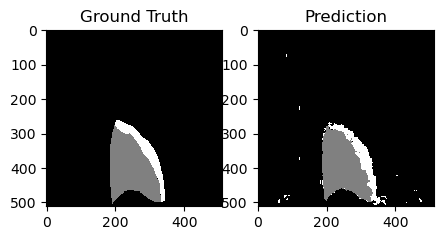

===== 图片 2 原始label =====
标签占比:
标签 背景: 90.56%
标签 煤: 7.27%
标签 煤矸石: 2.17%
煤矸石占比为: 23.03%
===== 图片 2 预测结果 =====
标签占比:
标签 背景: 90.55%
标签 煤: 6.67%
标签 煤矸石: 2.78%
煤矸石占比为: 29.42%


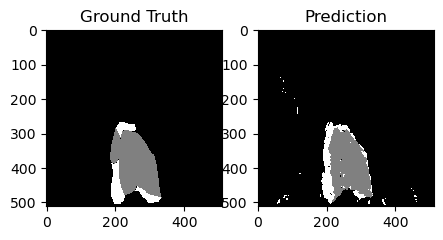

===== 图片 3 原始label =====
标签占比:
标签 背景: 88.95%
标签 煤: 1.29%
标签 煤矸石: 9.76%
煤矸石占比为: 88.36%
===== 图片 3 预测结果 =====
标签占比:
标签 背景: 89.78%
标签 煤: 1.73%
标签 煤矸石: 8.49%
煤矸石占比为: 83.04%


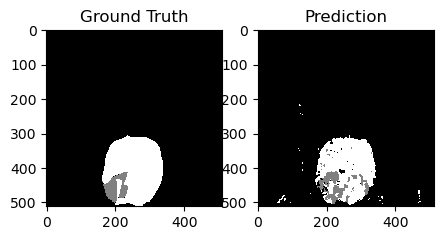

===== 图片 4 原始label =====
标签占比:
标签 背景: 89.25%
标签 煤: 1.14%
标签 煤矸石: 9.61%
煤矸石占比为: 89.43%
===== 图片 4 预测结果 =====
标签占比:
标签 背景: 89.49%
标签 煤: 2.39%
标签 煤矸石: 8.12%
煤矸石占比为: 77.23%


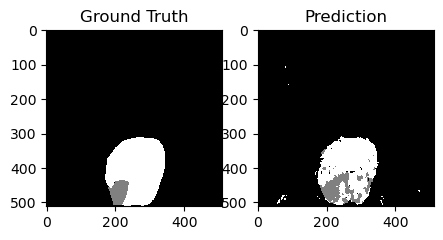

===== 图片 5 原始label =====
标签占比:
标签 背景: 92.47%
标签 煤: 1.20%
标签 煤矸石: 6.34%
煤矸石占比为: 84.13%
===== 图片 5 预测结果 =====
标签占比:
标签 背景: 92.68%
标签 煤: 2.03%
标签 煤矸石: 5.29%
煤矸石占比为: 72.29%


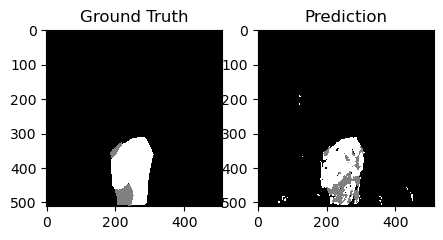

===== 图片 6 原始label =====
标签占比:
标签 背景: 93.62%
标签 煤: 2.32%
标签 煤矸石: 4.05%
煤矸石占比为: 63.59%
===== 图片 6 预测结果 =====
标签占比:
标签 背景: 94.62%
标签 煤: 1.97%
标签 煤矸石: 3.41%
煤矸石占比为: 63.38%


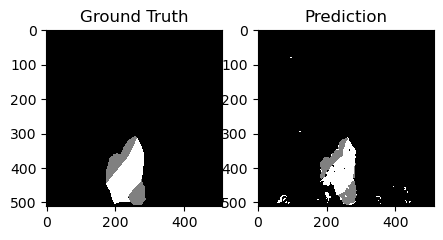

===== 图片 7 原始label =====
标签占比:
标签 背景: 90.99%
标签 煤: 3.62%
标签 煤矸石: 5.39%
煤矸石占比为: 59.79%
===== 图片 7 预测结果 =====
标签占比:
标签 背景: 92.13%
标签 煤: 3.68%
标签 煤矸石: 4.19%
煤矸石占比为: 53.23%


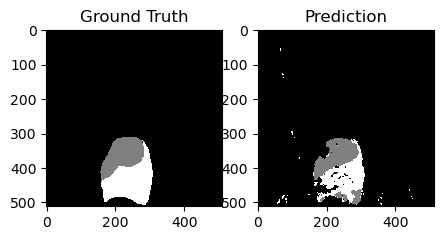

===== 图片 8 原始label =====
标签占比:
标签 背景: 88.71%
标签 煤: 5.07%
标签 煤矸石: 6.22%
煤矸石占比为: 55.10%
===== 图片 8 预测结果 =====
标签占比:
标签 背景: 91.43%
标签 煤: 3.18%
标签 煤矸石: 5.38%
煤矸石占比为: 62.86%


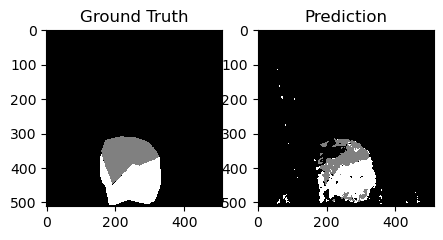

===== 图片 1 原始label =====
标签占比:
标签 背景: 90.98%
标签 煤: 3.82%
标签 煤矸石: 5.20%
煤矸石占比为: 57.61%
===== 图片 1 预测结果 =====
标签占比:
标签 背景: 92.69%
标签 煤: 3.00%
标签 煤矸石: 4.31%
煤矸石占比为: 58.94%


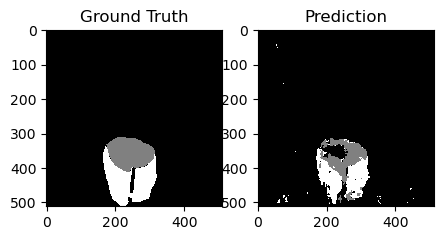

===== 图片 2 原始label =====
标签占比:
标签 背景: 93.60%
标签 煤: 0.38%
标签 煤矸石: 6.02%
煤矸石占比为: 93.99%
===== 图片 2 预测结果 =====
标签占比:
标签 背景: 92.97%
标签 煤: 1.37%
标签 煤矸石: 5.66%
煤矸石占比为: 80.57%


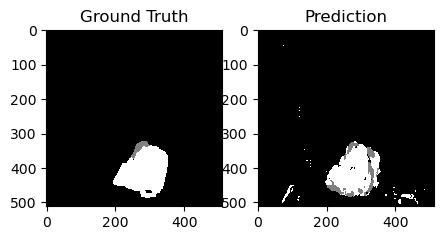

===== 图片 3 原始label =====
标签占比:
标签 背景: 90.69%
标签 煤: 1.05%
标签 煤矸石: 8.26%
煤矸石占比为: 88.75%
===== 图片 3 预测结果 =====
标签占比:
标签 背景: 91.91%
标签 煤: 0.58%
标签 煤矸石: 7.52%
煤矸石占比为: 92.88%


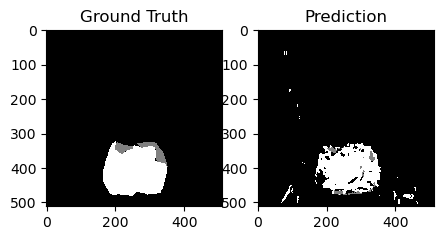

===== 图片 4 原始label =====
标签占比:
标签 背景: 95.14%
标签 煤: 3.16%
标签 煤矸石: 1.70%
煤矸石占比为: 34.96%
===== 图片 4 预测结果 =====
标签占比:
标签 背景: 94.90%
标签 煤: 2.08%
标签 煤矸石: 3.03%
煤矸石占比为: 59.27%


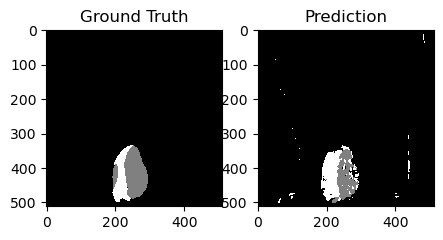

===== 图片 5 原始label =====
标签占比:
标签 背景: 94.21%
标签 煤: 2.50%
标签 煤矸石: 3.29%
煤矸石占比为: 56.76%
===== 图片 5 预测结果 =====
标签占比:
标签 背景: 95.18%
标签 煤: 1.10%
标签 煤矸石: 3.72%
煤矸石占比为: 77.18%


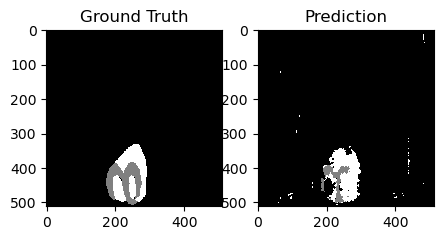

===== 图片 6 原始label =====
标签占比:
标签 背景: 93.17%
标签 煤: 2.85%
标签 煤矸石: 3.98%
煤矸石占比为: 58.30%
===== 图片 6 预测结果 =====
标签占比:
标签 背景: 93.20%
标签 煤: 2.25%
标签 煤矸石: 4.55%
煤矸石占比为: 66.89%


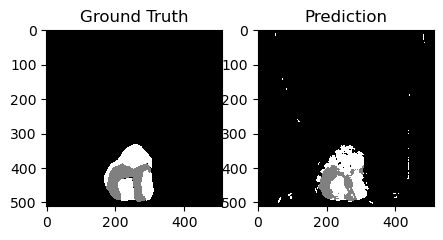

===== 图片 7 原始label =====
标签占比:
标签 背景: 93.32%
标签 煤: 2.73%
标签 煤矸石: 3.95%
煤矸石占比为: 59.15%
===== 图片 7 预测结果 =====
标签占比:
标签 背景: 93.13%
标签 煤: 1.42%
标签 煤矸石: 5.45%
煤矸石占比为: 79.34%


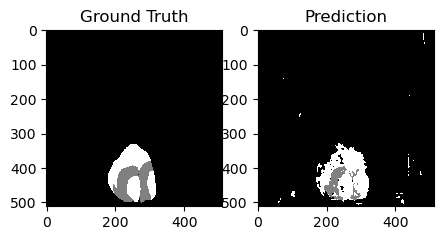

===== 图片 8 原始label =====
标签占比:
标签 背景: 96.47%
标签 煤: 1.07%
标签 煤矸石: 2.45%
煤矸石占比为: 69.53%
===== 图片 8 预测结果 =====
标签占比:
标签 背景: 96.43%
标签 煤: 0.76%
标签 煤矸石: 2.81%
煤矸石占比为: 78.61%


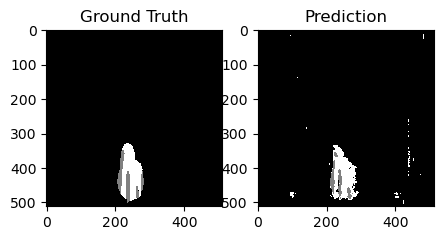

===== 图片 1 原始label =====
标签占比:
标签 背景: 94.45%
标签 煤: 3.36%
标签 煤矸石: 2.19%
煤矸石占比为: 39.53%
===== 图片 1 预测结果 =====
标签占比:
标签 背景: 94.99%
标签 煤: 2.81%
标签 煤矸石: 2.21%
煤矸石占比为: 44.01%


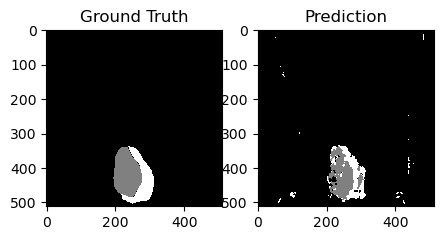

===== 图片 2 原始label =====
标签占比:
标签 背景: 93.08%
标签 煤: 2.61%
标签 煤矸石: 4.30%
煤矸石占比为: 62.22%
===== 图片 2 预测结果 =====
标签占比:
标签 背景: 92.99%
标签 煤: 2.57%
标签 煤矸石: 4.43%
煤矸石占比为: 63.25%


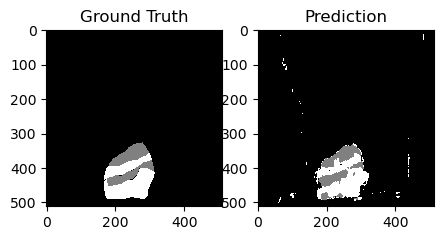

===== 图片 3 原始label =====
标签占比:
标签 背景: 93.51%
标签 煤: 2.87%
标签 煤矸石: 3.62%
煤矸石占比为: 55.75%
===== 图片 3 预测结果 =====
标签占比:
标签 背景: 92.56%
标签 煤: 3.54%
标签 煤矸石: 3.89%
煤矸石占比为: 52.34%


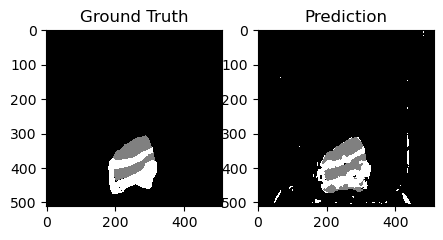

===== 图片 4 原始label =====
标签占比:
标签 背景: 94.62%
标签 煤: 2.61%
标签 煤矸石: 2.78%
煤矸石占比为: 51.57%
===== 图片 4 预测结果 =====
标签占比:
标签 背景: 93.91%
标签 煤: 3.20%
标签 煤矸石: 2.89%
煤矸石占比为: 47.47%


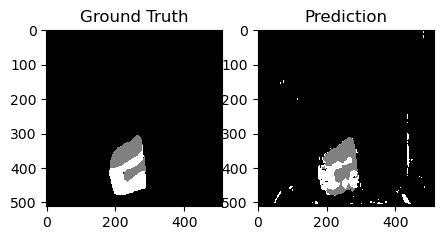

===== 图片 5 原始label =====
标签占比:
标签 背景: 95.27%
标签 煤: 1.54%
标签 煤矸石: 3.18%
煤矸石占比为: 67.32%
===== 图片 5 预测结果 =====
标签占比:
标签 背景: 94.92%
标签 煤: 1.38%
标签 煤矸石: 3.70%
煤矸石占比为: 72.86%


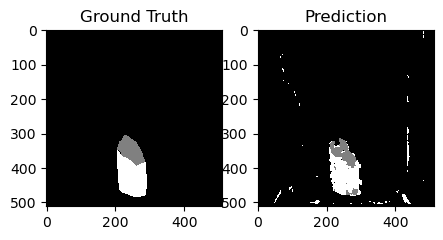

===== 图片 6 原始label =====
标签占比:
标签 背景: 92.95%
标签 煤: 1.69%
标签 煤矸石: 5.37%
煤矸石占比为: 76.07%
===== 图片 6 预测结果 =====
标签占比:
标签 背景: 92.77%
标签 煤: 1.52%
标签 煤矸石: 5.72%
煤矸石占比为: 79.03%


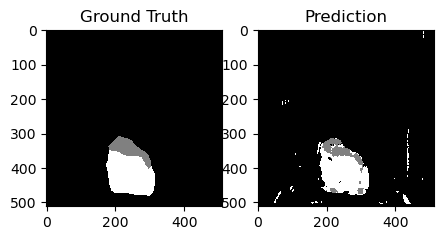

===== 图片 7 原始label =====
标签占比:
标签 背景: 93.04%
标签 煤: 1.41%
标签 煤矸石: 5.55%
煤矸石占比为: 79.75%
===== 图片 7 预测结果 =====
标签占比:
标签 背景: 92.59%
标签 煤: 1.30%
标签 煤矸石: 6.11%
煤矸石占比为: 82.52%


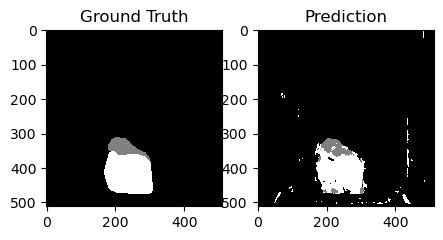

===== 图片 8 原始label =====
标签占比:
标签 背景: 93.36%
标签 煤: 1.26%
标签 煤矸石: 5.39%
煤矸石占比为: 81.10%
===== 图片 8 预测结果 =====
标签占比:
标签 背景: 92.67%
标签 煤: 1.25%
标签 煤矸石: 6.08%
煤矸石占比为: 82.97%


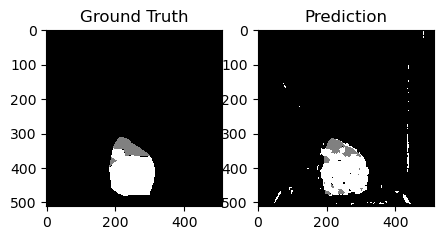

===== 图片 1 原始label =====
标签占比:
标签 背景: 96.19%
标签 煤: 0.94%
标签 煤矸石: 2.87%
煤矸石占比为: 75.33%
===== 图片 1 预测结果 =====
标签占比:
标签 背景: 95.53%
标签 煤: 1.85%
标签 煤矸石: 2.62%
煤矸石占比为: 58.57%


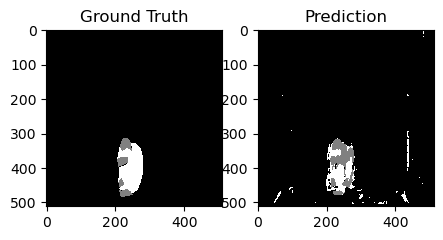

===== 图片 2 原始label =====
标签占比:
标签 背景: 93.21%
标签 煤: 2.85%
标签 煤矸石: 3.94%
煤矸石占比为: 58.03%
===== 图片 2 预测结果 =====
标签占比:
标签 背景: 93.06%
标签 煤: 4.13%
标签 煤矸石: 2.81%
煤矸石占比为: 40.48%


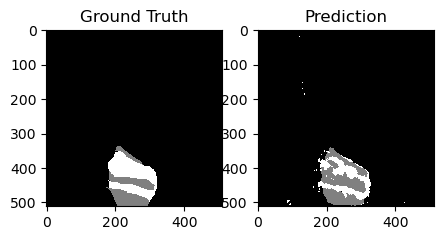

===== 图片 3 原始label =====
标签占比:
标签 背景: 88.74%
标签 煤: 5.91%
标签 煤矸石: 5.35%
煤矸石占比为: 47.51%
===== 图片 3 预测结果 =====
标签占比:
标签 背景: 89.08%
标签 煤: 5.27%
标签 煤矸石: 5.64%
煤矸石占比为: 51.69%


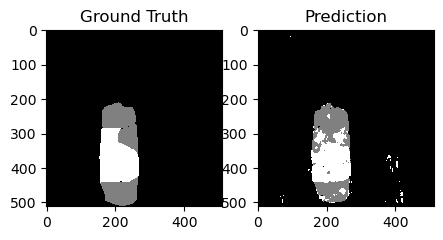

===== 图片 4 原始label =====
标签占比:
标签 背景: 88.66%
标签 煤: 4.98%
标签 煤矸石: 6.36%
煤矸石占比为: 56.09%
===== 图片 4 预测结果 =====
标签占比:
标签 背景: 88.97%
标签 煤: 6.72%
标签 煤矸石: 4.31%
煤矸石占比为: 39.07%


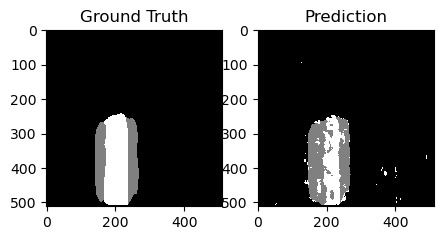

===== 图片 5 原始label =====
标签占比:
标签 背景: 89.10%
标签 煤: 6.93%
标签 煤矸石: 3.97%
煤矸石占比为: 36.45%
===== 图片 5 预测结果 =====
标签占比:
标签 背景: 88.56%
标签 煤: 7.32%
标签 煤矸石: 4.12%
煤矸石占比为: 35.99%


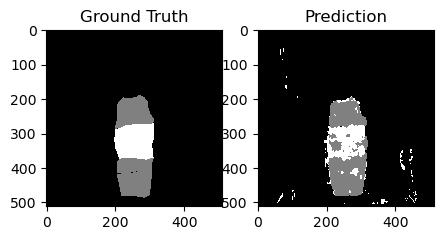

===== 图片 6 原始label =====
标签占比:
标签 背景: 88.93%
标签 煤: 4.64%
标签 煤矸石: 6.44%
煤矸石占比为: 58.14%
===== 图片 6 预测结果 =====
标签占比:
标签 背景: 88.97%
标签 煤: 4.49%
标签 煤矸石: 6.54%
煤矸石占比为: 59.30%


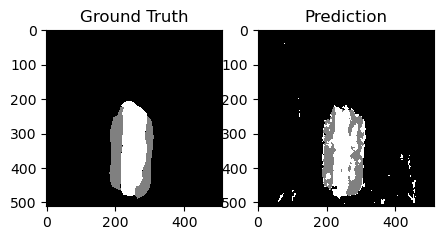

===== 图片 7 原始label =====
标签占比:
标签 背景: 91.49%
标签 煤: 2.10%
标签 煤矸石: 6.41%
煤矸石占比为: 75.37%
===== 图片 7 预测结果 =====
标签占比:
标签 背景: 91.18%
标签 煤: 2.58%
标签 煤矸石: 6.24%
煤矸石占比为: 70.74%


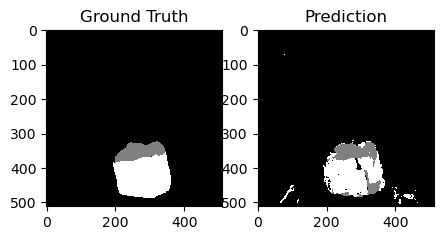

===== 图片 8 原始label =====
标签占比:
标签 背景: 93.37%
标签 煤: 1.21%
标签 煤矸石: 5.42%
煤矸石占比为: 81.77%
===== 图片 8 预测结果 =====
标签占比:
标签 背景: 93.38%
标签 煤: 0.97%
标签 煤矸石: 5.65%
煤矸石占比为: 85.37%


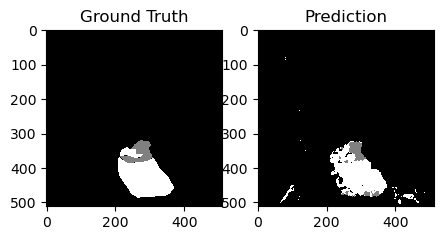

===== 图片 1 原始label =====
标签占比:
标签 背景: 91.80%
标签 煤: 0.78%
标签 煤矸石: 7.42%
煤矸石占比为: 90.48%
===== 图片 1 预测结果 =====
标签占比:
标签 背景: 92.79%
标签 煤: 0.70%
标签 煤矸石: 6.51%
煤矸石占比为: 90.30%


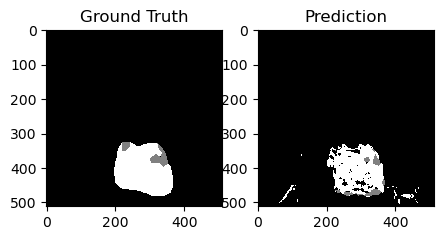

===== 图片 2 原始label =====
标签占比:
标签 背景: 90.65%
标签 煤: 1.31%
标签 煤矸石: 8.04%
煤矸石占比为: 86.01%
===== 图片 2 预测结果 =====
标签占比:
标签 背景: 91.22%
标签 煤: 0.74%
标签 煤矸石: 8.04%
煤矸石占比为: 91.54%


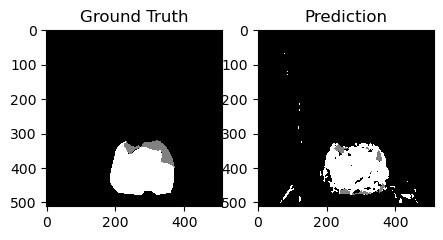

===== 图片 3 原始label =====
标签占比:
标签 背景: 92.10%
标签 煤: 0.98%
标签 煤矸石: 6.92%
煤矸石占比为: 87.59%
===== 图片 3 预测结果 =====
标签占比:
标签 背景: 91.97%
标签 煤: 1.65%
标签 煤矸石: 6.37%
煤矸石占比为: 79.40%


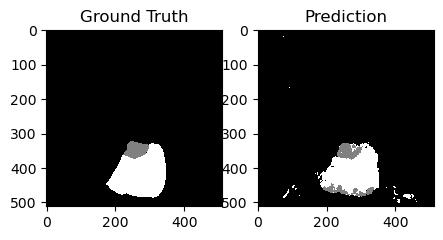

===== 图片 4 原始label =====
标签占比:
标签 背景: 87.84%
标签 煤: 4.20%
标签 煤矸石: 7.96%
煤矸石占比为: 65.44%
===== 图片 4 预测结果 =====
标签占比:
标签 背景: 87.92%
标签 煤: 3.38%
标签 煤矸石: 8.70%
煤矸石占比为: 72.01%


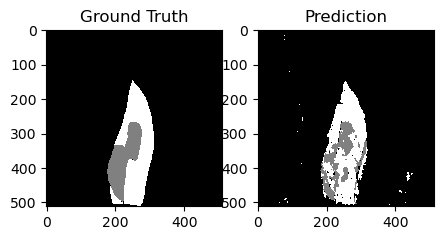

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def label_mapping(label):
    if label == 0:
        return "背景"
    elif label == 1:
        return "煤"
    elif label == 2:
        return "煤矸石"

def print_portion(prediction):
    # 计算预测结果中各标签的占比
    unique, counts = np.unique(prediction, return_counts=True)
    label_counts = dict(zip(unique, counts))
    total_pixels = prediction.size
    proportions = {label: count / total_pixels for label, count in label_counts.items()}

    # 打印标签占比
    print("标签占比:")
    for label1, proportion in proportions.items():
        # Ensure label mapping does not fail with a KeyError
        label_name = label_mapping(label1) if label1 in [0, 1, 2] else "未知"
        print(f"标签 {label_name}: {proportion:.2%}")

    if 1 in proportions and 2 in proportions:
        print(f"煤矸石占比为: {proportions[2] / (proportions[1] + proportions[2]):.2%}")
    else:
        print("煤或煤矸石未出现在预测中。")

def visualize_prediction(model, data_loader, device):
    model.eval()  # 确保模型处于评估模式
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            # 遍历每张图片
            for idx in range(images.size(0)):
                label = labels[idx].cpu().numpy()
                prediction = preds[idx].cpu().numpy()

                print(f"===== 图片 {idx+1} 原始label =====")
                print_portion(label)

                print(f"===== 图片 {idx+1} 预测结果 =====")
                print_portion(prediction)

                # 可视化，只展示Ground Truth和Prediction
                fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))  # 改为显示两列
                ax[0].imshow(label, cmap='gray')
                ax[0].set_title('Ground Truth')
                ax[1].imshow(prediction, cmap='gray')
                ax[1].set_title('Prediction')
                plt.show()

# 测试并可视化结果
visualize_prediction(model, test_loader, device)


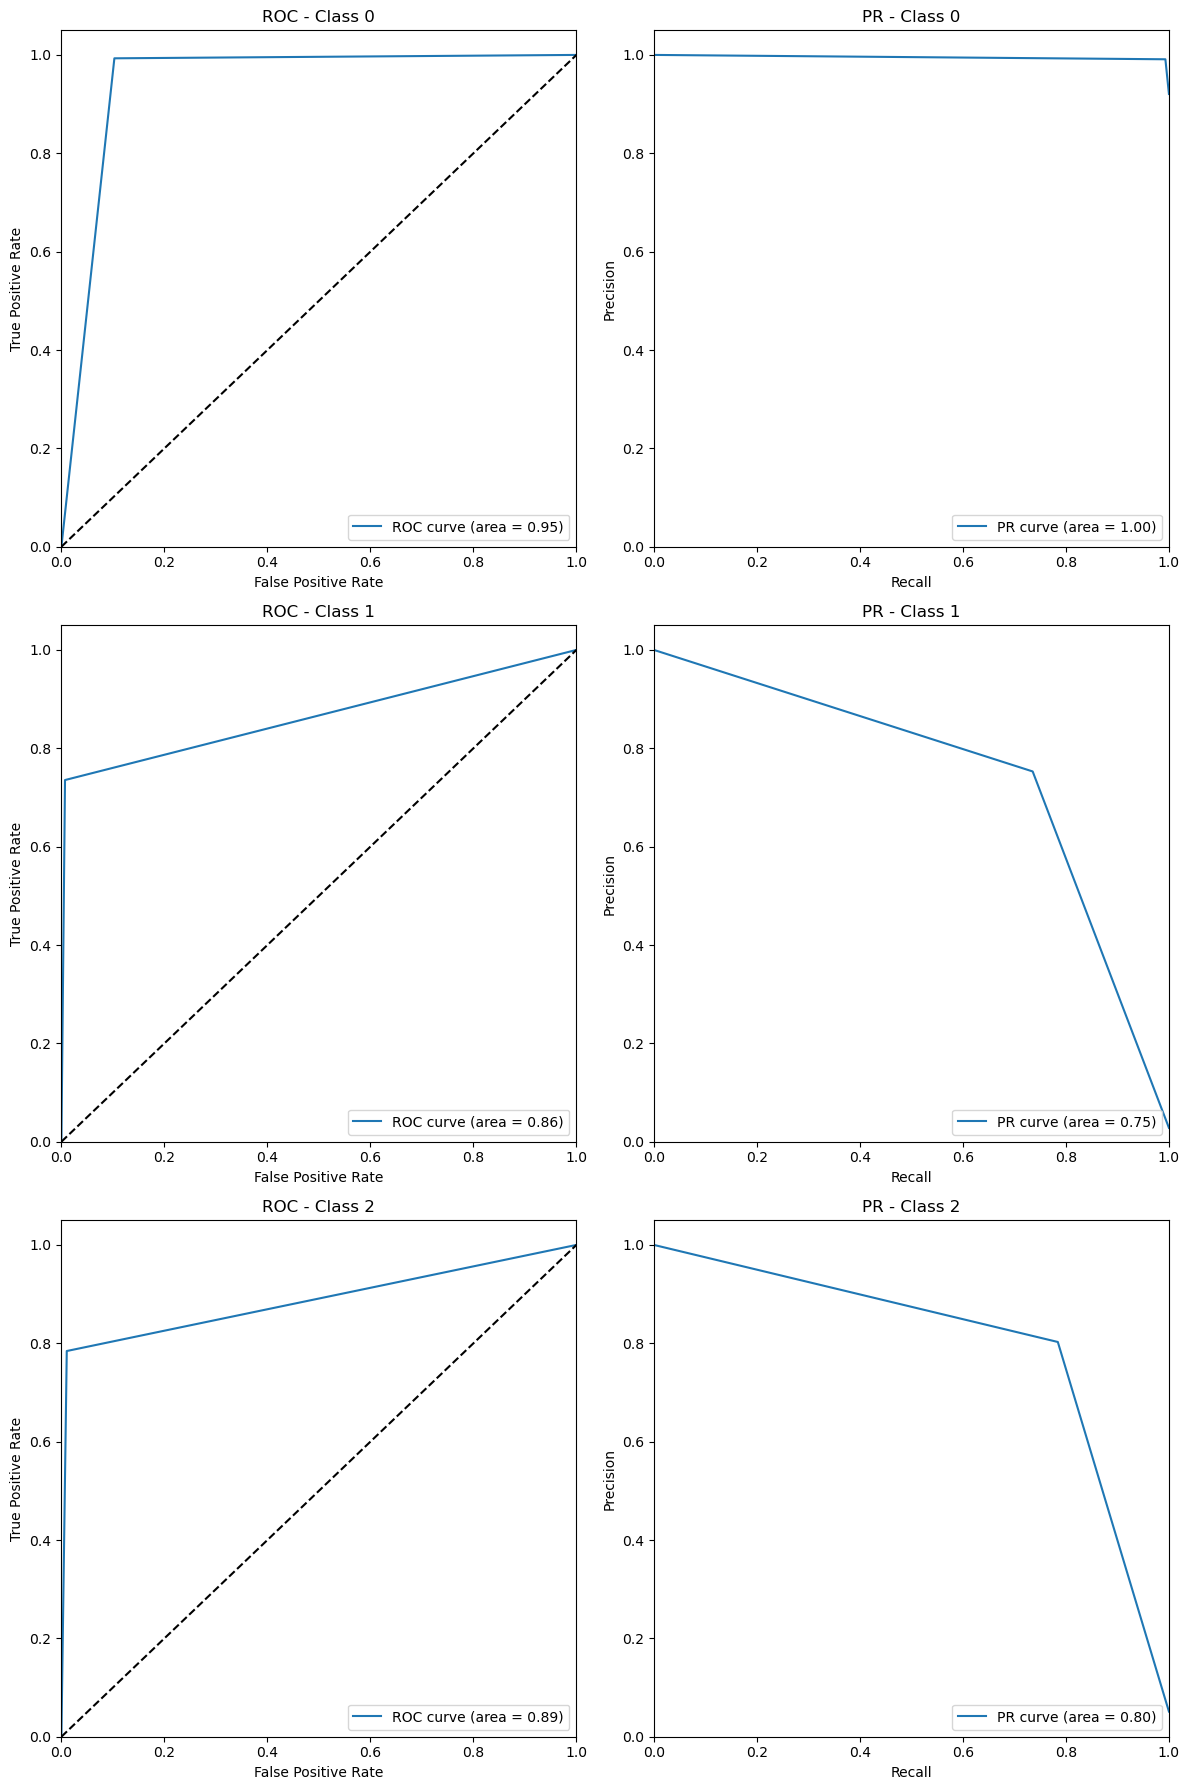

In [11]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from fcn import MyUNet
import torch.optim as optim


# 设置打印选项，禁用省略
np.set_printoptions(threshold=1000)

def get_predictions_and_labels(model, data_loader, device):
    model.eval()
    all_labels = []
    all_scores = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # 获取预测分数（softmax后的概率）
            scores = torch.softmax(outputs, dim=1)  # (batch_size, num_classes, H, W)
            max_scores, max_indices = torch.max(scores, dim=1)
            #max_indices_np = max_indices.cpu().numpy()  # 如果是在 PyTorch 中

            # 选择要统计的图像索引，例如第一张图像
            #selected_image = max_indices_np[0]
            
            # 使用 np.unique 计算每个类别索引的出现次数
            #unique_values, counts = np.unique(selected_image, return_counts=True)
            
            # 打印结果
            #for value, count in zip(unique_values, counts):
            ##    print(f"Value {value} appears {count} times")
            #break
            #print(labels.cpu().numpy().shape)
            all_labels.append(labels.cpu().numpy().flatten())
            all_scores.append(max_indices.cpu().numpy().flatten())
    
    all_labels = np.concatenate(all_labels)
    all_scores = np.concatenate(all_scores)
    
    return all_labels, all_scores

def plot_roc_pr_curves(labels, predictions, num_classes):
    fig, axs = plt.subplots(num_classes, 2, figsize=(12, 18))

    for i in range(num_classes):
        # 生成每个类别的伪概率
        # 对于每个类别i，预测为i的设置为1，否则为0
        pseudo_probabilities = (predictions == i).astype(float)

        # 将标签转换为二分类格式：当前类别为1，其他类别为0
        binary_labels = (labels == i).astype(int)

        # 计算 ROC 曲线
        fpr, tpr, _ = roc_curve(binary_labels, pseudo_probabilities)
        roc_auc = auc(fpr, tpr)

        # 计算 PR 曲线
        precision, recall, _ = precision_recall_curve(binary_labels, pseudo_probabilities)
        pr_auc = auc(recall, precision)

        # 绘制 ROC 曲线
        axs[i, 0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        axs[i, 0].plot([0, 1], [0, 1], 'k--')
        axs[i, 0].set_xlim([0.0, 1.0])
        axs[i, 0].set_ylim([0.0, 1.05])
        axs[i, 0].set_xlabel('False Positive Rate')
        axs[i, 0].set_ylabel('True Positive Rate')
        axs[i, 0].set_title(f'ROC - Class {i}')
        axs[i, 0].legend(loc="lower right")
        
        # 绘制 PR 曲线
        axs[i, 1].plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
        axs[i, 1].set_xlim([0.0, 1.0])
        axs[i, 1].set_ylim([0.0, 1.05])
        axs[i, 1].set_xlabel('Recall')
        axs[i, 1].set_ylabel('Precision')
        axs[i, 1].set_title(f'PR - Class {i}')
        axs[i, 1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

# 加载模型和优化器状态
checkpoint = torch.load('model_and_optimizer.pth')
model = MyUNet(n_channels=3, n_classes=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 不要忘记将模型发送到正确的设备
model.eval()

# 获取测试集上的预测结果和真实标签
labels, scores = get_predictions_and_labels(model, test_loader, device)
# 确保长度一致
assert len(labels) == scores.shape[0], "Labels and scores length mismatch"

# 绘制 ROC 曲线和 PR 曲线
plot_roc_pr_curves(labels, scores, num_classes=3)